In this notebook, we show how different metrics can be used to choose the number of GMM components to perform density estimation of the data. We compare the default validation log-likelihood with the Akaike information criterion (AIC) and Bayesian information criterion (BIC) on the second latent - first radial bin pair of the halo data. We ignore the MI calculation, and only look at the different metric values to choose the number of GMM components.

### Import packages

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from gmm_mi.mi import EstimateMI
from gmm_mi.param_holders import GMMFitParamHolder, SelectComponentsParamHolder, MIDistParamHolder

### Load the data

In [2]:
truth = np.load("../deep_learning/halo_data/true_log_rho_per_radial_bin_sim11_testset.npy")
epoch = 27
lmean, lstd = np.load(f"../deep_learning/halo_data/latent_mean_11_testset_epoch_{epoch}.npy"), np.load(f"../deep_learning/halo_data/latent_std_11_testset_epoch_{epoch}.npy")

In [3]:
radial_bins = truth.shape[0]
latents = lmean.shape[1]

### Calculate MI for all latents and radial bins

In [4]:
results_file = f'./results/AIC_BIC_logL.npy'
max_components = 15

if os.path.isfile(results_file) :
    print('Not running this cell, since results file already exists. '
          'Loading pre-computed results...')
    AIC_BIC_logl = np.load(results_file)
else:
    print(f'Estimating MI, and saving results...')
    AIC_BIC_logl = np.zeros((max_components, 3))
    # parameters for every GMM fit that is being run
    gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-5, reg_covar=1e-12)
    
    # parameters to choose the number of components
    select_components_params = SelectComponentsParamHolder(n_inits=3,
                                                       n_folds=2,
                                                       max_components=max_components,
                                                       # increase patience only
                                                       # to show up to 15 components
                                                       patience=100)

    for radial_bin in range(radial_bins):
        for latent in range(latents):
            if latent != 1:
                continue
            samples = np.random.default_rng(42).normal(lmean[:, latent], lstd[:, latent], len(lmean[:, latent]))
            X = np.stack((samples, truth[radial_bin]), axis=0).T

            mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                                      select_components_params=select_components_params)
            mi_estimator.fit(X)    

            # store results
            for component in range(max_components):
                AIC_BIC_logl[component, 0] = mi_estimator.results_dict[component+1]['aic']
                AIC_BIC_logl[component, 1] = mi_estimator.results_dict[component+1]['bic']
                AIC_BIC_logl[component, 2] = mi_estimator.results_dict[component+1]['valid_score']

            np.save(results_file, AIC_BIC_logl)
            # we break since we are only interested in the second latent-radial bin pair
            break
        break

Estimating MI, and saving results...


/home/dpiras/.conda/envs/MI/lib/python3.9/site-packages/gmm_mi/mi.py:489: ConvergenceWarning: Convergence in the number of GMM components was not reached. Try increasing max_components or threshold_components, or decreasing the patience.
  warnings.warn(f"Convergence in the number of GMM components was not reached. "\


Note that the ConvergenceWarning in this case can be ignored, since we artificially set a very high patience, and we do not care about MI in this case.

### Plot results

In [5]:
# negative since we considered the opposite in GMM-MI
aics = AIC_BIC_logl[:, 0]
bics = AIC_BIC_logl[:, 1]
validation_ll = AIC_BIC_logl[:, 2]

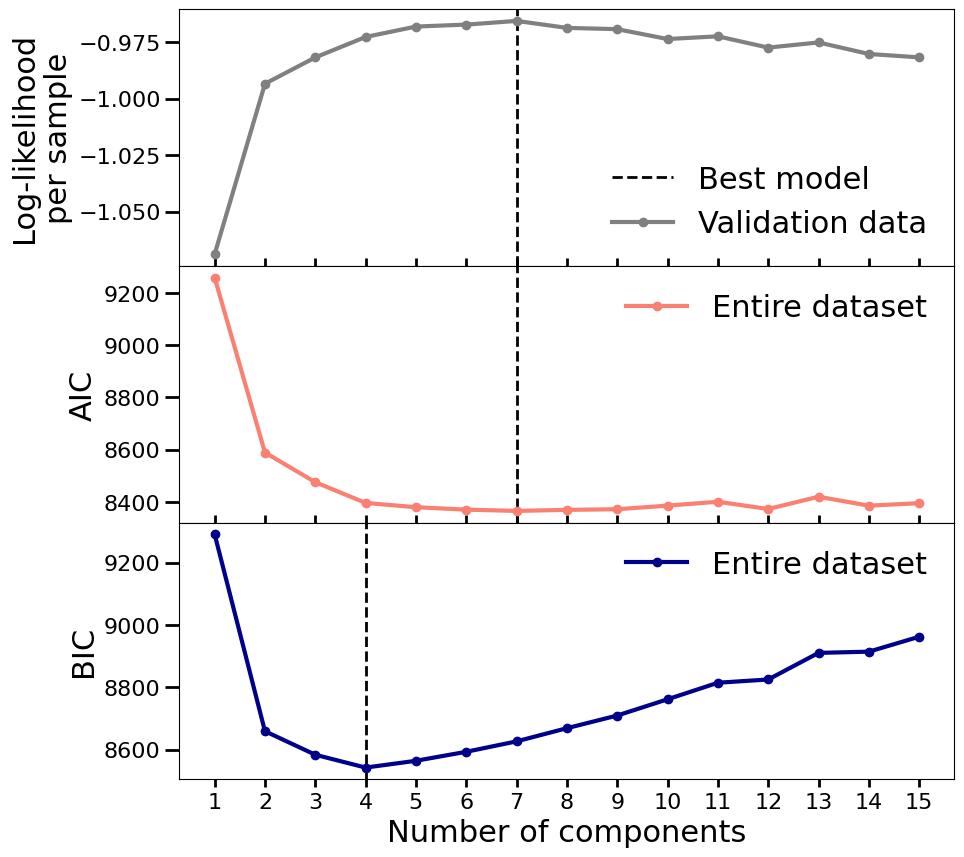

In [6]:
legendsize = 22
labelsize = 16
fig, (ax, ax1, ax2) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

ax.axvline(np.argmax(validation_ll)+1, color='k', lw=2, ls='--', label='Best model')
ax.plot(np.arange(1, max_components+1), validation_ll, lw=3, linestyle='-', 
        marker='o', color='grey', label='Validation data')
ax.set_ylabel("Log-likelihood\nper sample", fontsize=legendsize)
ax.set_xticks(np.arange(1, max_components+1))
ax.tick_params(axis='x', which='both', labelsize=labelsize, direction="in", length=6, width=2)
ax.tick_params(axis='y', which='both', labelsize=labelsize, length=10, width=2)
ax.legend(fontsize=legendsize, frameon=False)

ax1.axvline(np.argmin(aics)+1, color='k', lw=2, ls='--')
ax1.plot(np.arange(1, max_components+1), aics[:], lw=3, linestyle='-', 
         marker='o', color='salmon', label='Entire dataset')
ax1.set_ylabel(r"AIC", fontsize=legendsize)
ax1.tick_params(axis='x', which='both', labelsize=labelsize, direction="in", length=6, width=2)
ax1.tick_params(axis='y', which='both', labelsize=labelsize, length=10, width=2)
ax1.set_xticks(np.arange(1, max_components+1))
ax1.legend(fontsize=legendsize, frameon=False)

ax2.axvline(np.argmin(bics)+1, color='k', lw=2, ls='--')
ax2.plot(np.arange(1, max_components+1), bics[:], lw=3, linestyle='-', 
         marker='o', color='darkblue', label='Entire dataset')
ax2.set_xlabel('Number of components', fontsize=legendsize)
ax2.set_ylabel(r"BIC", fontsize=legendsize)
ax2.tick_params(axis='x', which='both', labelsize=labelsize, length=6, width=2)
ax2.tick_params(axis='y', which='both', labelsize=labelsize, length=10, width=2)
ax2.set_xticks(np.arange(1, max_components+1))
ax2.legend(fontsize=legendsize, frameon=False)

plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig('./figures/val_AIC_BIC.pdf', bbox_inches='tight');